# Zu welchem Genre gehört das Filmposter

Ablauf:

1. Importieren von allen Bibliotheken
2. Einlesen der csv Datei
3. Datenbereinigung
4. Herunterladen der Bilder
5. Input Pipeline erstellen
6. Ki Model bauen
7. Model trainieren und evaluieren
8. Exportieren & sichern des Models

In [8]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import shutil
import multiprocessing
import urllib.error
import urllib.request

from joblib import Parallel, delayed
from time import time


from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

from utils import *

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

## Laden der Daten

In [9]:
movie_data = pd.read_csv("./data/MovieGenre.csv",
                          sep=",", encoding='unicode_escape', index_col=None)
movie_data.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


## Datenbereinigung

In [10]:
# Entfernen von Null Werten
movie_data.dropna(subset=['imdbId', 'Genre', 'Poster'], inplace=True)

### Herunterladen der Daten (Parallel)

In [11]:
def download_parallel(movies, image_dir):
    # Create list of filenames
    filenames = movies['imdbId'].apply(lambda imbdId : os.path.join(image_dir, str(imbdId)+'.jpg'))
    # Create list of image urls
    urls = movies['Poster']

    # Create destination directory
    if os.path.exists(image_dir):
        print("Directory '{}' already exists and will be deleted.".format(image_dir))
        shutil.rmtree(image_dir)
    print("Created new directory '{}'".format(image_dir))
    os.makedirs(image_dir)

    # Define function to download one single image
    def download_image(url, filename):
        try:
            urllib.request.urlretrieve(url, filename)
            return 0
        except:
            return os.path.basename(filename).split('.')[0]

    # Download images in parallel
    start = time()
    print("\nDownloading...")
    num_cores = multiprocessing.cpu_count()
    ko_list = Parallel(n_jobs=num_cores)(delayed(download_image)(u, f) for f, u in zip(filenames, urls))

    print("\nDownload in parallel mode took %d seconds." %(time()-start))
    print("Success:", len([i for i in ko_list if i==0]))
    print("Errors:", len([i for i in ko_list if i!=0]))

    # Remove not downloaded posters from the dataframe
    ko_index = movies[movies['imdbId'].isin(ko_list)].index
    movies = movies.drop(ko_index)

    return movies


destination = './data/movie-posters'
movie_data = download_parallel(movie_data, destination)

munge_dir = "./data"
if not os.path.exists(munge_dir):
    os.makedirs(munge_dir)
movie_data.to_csv(os.path.join(munge_dir, "movies.csv"), index=False)

Created new directory './data/movie-posters'

Downloading...

Download in parallel mode took 1034 seconds.
Success: 36337
Errors: 2926


In [ ]:
movie_data = pd.read_csv("./data/movies.csv")
print("Number of movie posters in last download: {}\n".format(len(movie_data)))
movie_data.head(3)

## Input Pipeline erstellen

In [12]:
X_train, X_val, y_train, y_val = train_test_split(movie_data['imdbId'], movie_data['Genre'], test_size=0.2, random_state=44)
print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))

# we need files instead of imdbIds
X_train = [os.path.join('./data/movie_poster/images', str(f)+'.jpg') for f in X_train]
X_val = [os.path.join('./data/movie_poster/images', str(f)+'.jpg') for f in X_val]
print(X_train[:3])
print(X_val[:3])

y_train = list(y_train)
y_val = list(y_val)
print(y_train[:3])

Number of posters for training:  31410
Number of posters for validation:  7853
['./data/movie_poster/images/104129.jpg', './data/movie_poster/images/470913.jpg', './data/movie_poster/images/99615.jpg']
['./data/movie_poster/images/1758610.jpg', './data/movie_poster/images/68723.jpg', './data/movie_poster/images/3750826.jpg']
['Drama|Music', 'Drama|Romance', 'Comedy|Crime']


Beispiel Bilder

FileNotFoundError: [Errno 2] No such file or directory: './data/movie_poster/images/104129.jpg'

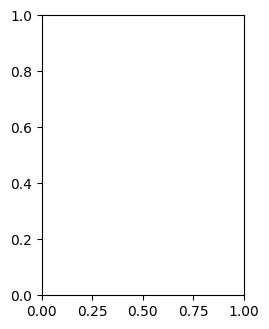

In [13]:
nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(12,4*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(X_train[i]))
    plt.title(y_train[i], size=10)
    plt.axis('off')

 Label encoding

In [14]:
# Fit the multi-label binarizer on the training set
print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

# transform the targets of the training and test sets
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

# Print example of movie posters and their binary targets
for i in range(3):
    print(X_train[i], y_train_bin[i])


Labels:
0. -
1. A
2. B
3. C
4. D
5. F
6. G
7. H
8. M
9. N
10. R
11. S
12. T
13. V
14. W
15. a
16. c
17. d
18. e
19. g
20. h
21. i
22. k
23. l
24. m
25. n
26. o
27. p
28. r
29. s
30. t
31. u
32. v
33. w
34. y
35. |
./data/movie_poster/images/104129.jpg [0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1]
./data/movie_poster/images/470913.jpg [0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1]
./data/movie_poster/images/99615.jpg [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1]


## Pipeline

In [15]:
IMG_SIZE = 224 # Height and Width of an Image
CHANNELS = 3 # 3 Stands for RGB

BATCH_SIZE = 256 # Big enough to measure an F1-score
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically


def parse_function(filename, label):
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

def create_dataset(filenames, labels, is_training=True):
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)

    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

2022-05-25 20:14:31.749811: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: ./data/movie_poster/images/1261978.jpg; No such file or directory
2022-05-25 20:14:31.749866: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: ./data/movie_poster/images/99615.jpg; No such file or directory
2022-05-25 20:14:31.749887: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: ./data/movie_poster/images/126250.jpg; No such file or directory
2022-05-25 20:14:31.749927: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: ./data/movie_poster/images/470913.jpg; No such file or directory
2022-05-25 20:14:31.749946: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: ./data/movie_poster/images/1052003.jpg; No such file or

NotFoundError: ./data/movie_poster/images/104129.jpg; No such file or directory
	 [[{{node ReadFile}}]] [Op:IteratorGetNext]

## Model bauen

In [ ]:
model = tf.keras.Sequential([
    # TODO:########################################################
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256,256, 3)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')

])

model.summary()

# Train

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.metrics.binary_crossentropy,
    metrics="accuracy")

start = time()
history_bce = model.fit(train_ds,
                            epochs=30,
                            validation_data=create_dataset(X_val, y_val_bin))